# Stocks news ingestion

Two options to run stocks demo (with kfpipeline and without).
1. run notebooks `01_ingest_news.ipynb`, `02_ingest_stocks.ipynb`, `03_model_training.ipynb`, `04_model_serving.ipynb`, `06_grafana_view`
2. or `01_ingest_news.ipynb`, `02_ingest_stocks.ipynb`, `05_stocks_pipeline`

> <b> Steps </b>
> * [project creation and prerequisits](#project-creation-and-prerequisits)
> * [Deploying sentiment analysis serving function from the function marketplace](#Deploying-sentiment-analysis-serving-function-from-the-function-marketplace)
> * [Creating a feature set and declaring the graph](#Creating-a-feature-set-and-declaring-the-graph)
> * [Dummy ingestion, Deploying ingestion service and getting ingestion endpoint](#Dummy-ingestion,-Deploying-ingestion-service-and-getting-ingestion-endpoint)
> * [Testing ingestion service](#Testing-ingestion-service)
> * [Creating scheduled mlrun job to invoke our function every time delta](#Creating-scheduled-mlrun-job-to-invoke-our-function-every-time-delta)

## project creation and prerequisits

In [1]:
# install prerequsits 
# prerequisits for the notebook is installing 2 packages yfinance yahoo_fin for uploading stocks data 
import importlib.util
import IPython

def install_missing_packages(packages):
    install_flag = False
    for package in packages:
        spec = importlib.util.find_spec(package)
        if spec is None:
            %pip install {package}
            install_flag = True
        else:     
            print("package {} installed".format(package))
        if install_flag:            
            print ("restarting kernerl due to package install")
            IPython.Application.instance().kernel.do_shutdown(True)
# For illustrative purposes.
packages  = ['yfinance', 'yahoo_fin']
install_missing_packages(packages)

package yfinance installed
package yahoo_fin installed


In [2]:
import mlrun
project = mlrun.get_or_create_project(name='stocks',user_project=True, context="src/")

> 2022-11-08 11:30:50,867 [info] loaded project stocks from MLRun DB


In [3]:
NUMBER_OF_STOCKS = 10

In [4]:
import os

# getting the sentiment analysis pretrained model (433M might take a while)
if not os.path.exists('src/model.pt'): 
    os.makedirs('src',exist_ok=True)
    print('getting model')
    !wget -O src/model.pt https://iguazio-sample-data.s3.amazonaws.com/models/model.pt 

## Deploying sentiment analysis serving function from the function marketplace

In [5]:
model_location = os.path.abspath('src/model.pt')
sentiment_analysis_serving = mlrun.import_function('hub://sentiment_analysis_serving').apply(mlrun.auto_mount())
sentiment_analysis_serving.add_model('sentiment_analysis_model', model_path=model_location,
                                      class_name='SentimentClassifierServing')

# sentiment_analysis_serving.with_http() # needed to provide http-endpoint to our serving graph

sentiment_analysis_serving.spec.readiness_timeout = 3600
address = sentiment_analysis_serving.deploy()
print(address)

> 2022-11-08 11:30:51,212 [info] Starting remote function deploy
2022-11-08 11:30:51  (info) Deploying function
2022-11-08 11:30:51  (info) Building
2022-11-08 11:30:51  (info) Staging files and preparing base images
2022-11-08 11:30:51  (info) Building processor image
2022-11-08 11:33:59  (info) Build complete
2022-11-08 11:34:35  (info) Function deploy complete
> 2022-11-08 11:34:36,259 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-sentiment-analysis-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-sentiment-analysis-serving-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}
http://stocks-dani-sentiment-analysis-serving-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/


## Creating a feature set and declaring the graph

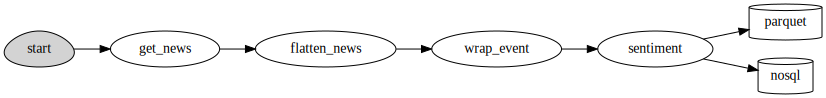

In [6]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import DateExtractor, MapValues
import yahoo_fin.stock_info as si

# creating feature set
news_set = fstore.FeatureSet("news", 
                                 entities=[fstore.Entity("ticker")],
                                 timestamp_key='Datetime', 
                                 description="stocks news feature set")

# setting up the graph
news_set.graph \
    .to(name='get_news', handler='get_news') \
    .to("storey.steps.Flatten", name="flatten_news") \
    .to(name='wrap_event', handler='wrap_event') \
    .to("sentiment_analysis", "sentiment", full_event=True, address=address) 

news_set.set_targets(with_defaults=True) 
news_set.plot(rankdir="LR", with_targets=True)

## Dummy ingestion, Deploying ingestion service and getting ingestion endpoint

In [7]:
# ingesting dummy (A MUST) 
import os
import datetime
import pandas as pd
# because were ingesting locally, code must be present !
from src.news import *

name = os.environ['V3IO_USERNAME']
now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

fstore.ingest(news_set,
              pd.DataFrame.from_dict({'ticker':[name],
                                      'Datetime': now,
                                      'n_stocks':NUMBER_OF_STOCKS}),
              overwrite=True)

Datetime            published  \
ticker                                            
A      2022-11-07 13:00:00  2022-11-07 13:00:00   
A      2022-11-04 16:33:04  2022-11-04 16:33:04   
A      2022-11-04 13:58:01  2022-11-04 13:58:01   
A      2022-11-03 13:45:01  2022-11-03 13:45:01   
A      2022-11-01 18:30:00  2022-11-01 18:30:00   
...                    ...                  ...   
ACN    2022-10-29 12:00:46  2022-10-29 12:00:46   
ACN    2022-10-28 06:44:00  2022-10-28 06:44:00   
ACN    2022-10-26 10:59:00  2022-10-26 10:59:00   
ACN    2022-10-26 09:47:00  2022-10-26 09:47:00   
ACN    2022-10-25 21:45:09  2022-10-25 21:45:09   

                                                  summary  \
ticker                                                      
A       SANTA CLARA Calif November 07 2022Agilent Tech...   
A       Skyworks SWKS fourthquarter fiscal 2022 result...   
A       Microchips MCHP secondquarter fiscal 2023 resu...   
A       Itron ITRI delivered earnings and revenue surp...   
A       SANTA CLARA Calif November 01 2022Agilent Tech...   
...                                                   ...   
ACN     Despite the fact that Accenture plc NYSEACN st...   
ACN     New research from Accenture NYSE ACN shows tha...   
ACN     NEW YORK October 26 2022Applications are now b...   
ACN     Monster Beverage Accenture and Match Group all...   
ACN     In the latest trading session Accenture ACN cl...   

                                                    title  sentiment  
ticker                                                                
A                   Agilent Joins the How2Recycle Program        1.0  
A       Skyworks SWKS Q4 Earnings Top Estimates Revenu...        1.0  
A       Microchip MCHP Q2 Earnings Top Estimates Sales...        1.0  
A                  Itron ITRI Meets Q3 Earnings Estimates        0.0  
A       Agilent to Announce FourthQuarter Fiscal Year ...        0.0  
...                                                   ...        ...  
ACN     Accenture plc NYSEACN insiders made a handsome...        0.5  
ACN     Chinese Companies Remain Committed to Digital ...        1.0  
ACN     FinTech Innovation Lab New York Now Accepting ...        0.0  
ACN     3 Unstoppable Growth Stocks to Buy and Hold Fo...        0.5  
ACN     Accenture ACN Outpaces Stock Market Gains What...        0.0  

[200 rows x 5 columns]

In [8]:
# Deploying ingestion service
# Define the HTTP Source to_dictable the HTTP trigger on our function and expose the endpoint.
# There is an option to declare key and timestamp inside the http source (here we dont send data through the http hence not needed)
http_source = mlrun.datastore.sources.HttpSource()
news_set.spec.source = http_source

# code_to_function our mlrun wrapped function to deploy the ingestion pipeline on.
# the serving runtimes enables the deployment of our feature set's computational graph
function = mlrun.code_to_function(name='get_news',kind='serving',image='mlrun/mlrun', requirements=['yahoo_fin','graphviz'], filename='src/news.py')

function.spec.readiness_timeout = 3600

run_config = fstore.RunConfig(function=function, local=False).apply(mlrun.mount_v3io())

# Deploying
news_set_endpoint = fstore.deploy_ingestion_service(featureset=news_set, run_config=run_config)

> 2022-11-08 11:37:43,772 [info] Starting remote function deploy
2022-11-08 11:37:43  (info) Deploying function
2022-11-08 11:37:43  (info) Building
2022-11-08 11:37:43  (info) Staging files and preparing base images
2022-11-08 11:37:44  (info) Building processor image
2022-11-08 11:39:29  (info) Build complete
2022-11-08 11:39:41  (info) Function deploy complete
> 2022-11-08 11:39:41,832 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-stocks-dani-get-news.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['stocks-dani-get-news-stocks-dani.default-tenant.app.vmdev93.lab.iguazeng.com/']}


## Testing ingestion service

In [9]:
import requests
import json

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

t = requests.post(news_set_endpoint,json={'ticker':['news'],
                                                 'Datetime': now,
                                                 'n_stocks':NUMBER_OF_STOCKS})
t.text

'{"id": "8ab0e779-5dfe-4cf6-aaef-8b6aafa3c06c"}'

## Creating scheduled mlrun job to invoke our function every time delta

In [13]:
import datetime

now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
body = {'ticker':['news'],
        'Datetime': now,
        'n_stocks':4}

# specifying '0 8 * * *' as schedule will trigger the function every day at 08:00 AM
fn = mlrun.code_to_function(name='ingestion_service_news',kind='job',image='mlrun/mlrun',handler='ingestion_service_invoker', filename='src/invoker.py')
fn.run(params={'endpoint':news_set_endpoint, 'body': body}, schedule='0 */1 * * *')

> 2022-11-08 12:08:58,238 [info] starting run ingestion-service-news-ingestion_service_invoker uid=b24c52ebf3974cb3b2417f3ac81aa2dd DB=http://mlrun-api:8080
> 2022-11-08 12:08:58,602 [info] task scheduled, {'schedule': '0 */1 * * *', 'project': 'stocks-dani', 'name': 'ingestion-service-news-ingestion_service_invoker'}


In [12]:
# Deleting the schedule job
mlrun.get_run_db().delete_schedule(project.name,'ingestion-service-news-ingestion_service_invoker')